In [2]:
%load_ext rpy2.ipython

import sys 
import os
import math
import datetime
import os
import json
import re
import pprint
import pandas as pd
from subprocess import *
import subprocess
from importlib import reload  # Python 3.4+ only.
from IPython.display import Image

cwd = os.getcwd()
print(cwd)
# Adapt this path, it needs to point on the folder containing experiments/exptools.py.
sys.path.insert(1, os.path.abspath("."))
from analysis import *


/home/adfaure/Projects/colmet_book/experiments/interferences/analysis


In [3]:
instances = [ 
    Instances("../data/grisou/increase_comms_randhostfile_grisou/no_kali_1bcast/"),
    Instances("../data/grisou/increase_comms_randhostfile_grisou/no_periods_1bcast/"),
    Instances("../data/grisou/increase_comms_randhostfile_grisou/periods10s_1bcast/"),
            ]

In [4]:
for insts in instances:
    print("--")
    print(insts.name, insts.get_mean_runtime())

--
0c9c7d7a 91.22708774999774
7e27dadb 90.78417604099741
00415e18 91.246311693998
deae99de 91.19507288000023
94faff77 91.72894562299915
no_kali_1bcast 91.2363187975985
--
31bb41d8 296.34203813300337
cf7d28f7 286.0411750059993
a09a5ad4 293.99241794699986
104de00f 301.67624451399934
c26c8923 141.4726040180003
no_periods_1bcast 263.90489592360046
--
8fa3574b 120.13236919700012
965df713 158.6225289289996
3f790a2f 158.26267615300094
327a38e9 158.03553991899938
53a93d03 154.00037770099883
periods10s_1bcast 149.81069837979976


/nix/store/2h7vm6ii3gwmsb98rprihzvk5wy3qcai-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

  warnings.warn(x, RRuntimeWarning)
/nix/store/2h7vm6ii3gwmsb98rprihzvk5wy3qcai-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: ✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

  warnings.warn(x, RRuntimeWarning)
/nix/store/2h7vm6ii3gwmsb98rprihzvk5wy3qcai-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

  warnings.warn(x, RRuntimeWarning)
/nix/store/2h7vm6ii3gwmsb98rprihzvk5wy3qcai-python3-3.7.4-env/lib/python3.7/site-packa

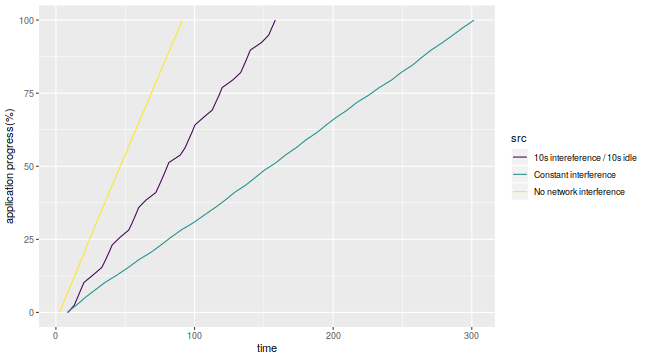

In [3]:
%%R -w 9 -h 5 --units in

library(tidyverse)
library(ggplot2)
library(viridis)

test =  read_csv("../data/grisou/increase_comms_randhostfile_grisou/no_kali_1bcast/00415e18/mpi_progress.csv") %>%
                  mutate(src = "No network interference") %>% 
        bind_rows( read_csv("../data/grisou/increase_comms_randhostfile_grisou/no_periods_1bcast/104de00f/mpi_progress.csv") %>%
                  mutate(src = "Constant interference") ) %>% 
        bind_rows( read_csv("../data/grisou/increase_comms_randhostfile_grisou/periods10s_1bcast/3f790a2f/mpi_progress.csv") %>%
                  mutate(src = "10s intereference / 10s idle") )
        
test = test %>% mutate(progress = loop/max(loop)*100)
test %>% ggplot(aes(x = max_comp_end, y = progress)) + ylab("application progress(%)") + xlab("time") + 
    geom_line(aes(color = src)) + 
    ggsave("/tmp/progress.png") + scale_colour_viridis_d()

# Analysis of differents kind of interferences


## Constant Interference

/nix/store/l81620lq18k9vjnl14xklp9zdm6wpprm-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Parsed with column specification:
cols(
  `#timestamp` = col_double(),
  cpu_cycles = col_double(),
  instructions = col_double(),
  rxp = col_double(),
  rxb = col_double(),
  txp = col_double(),
  txb = col_double(),
  X8 = col_logical()
)

  warnings.warn(x, RRuntimeWarning)
/nix/store/l81620lq18k9vjnl14xklp9zdm6wpprm-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Saving 12 x 8 in image

  warnings.warn(x, RRuntimeWarning)


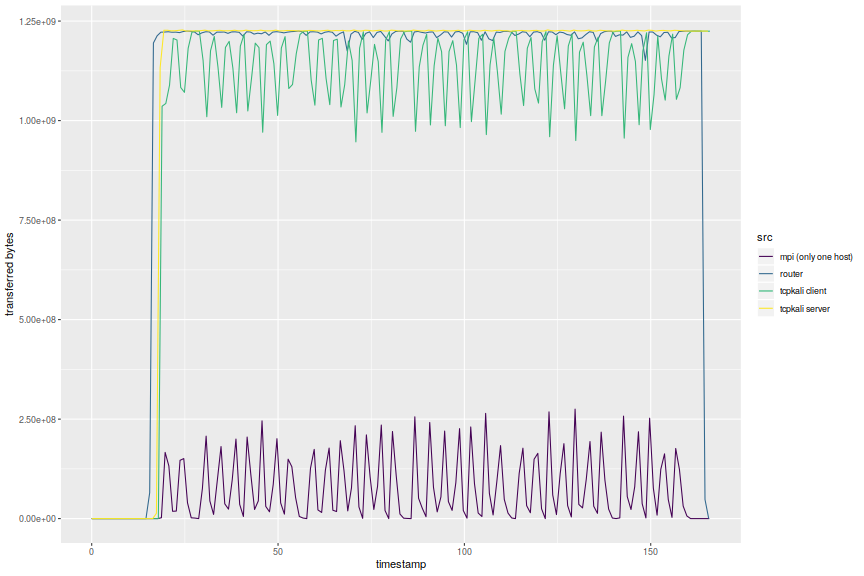

In [12]:
%%R -w 12 -h 8 --units in
library(tidyverse)
library(viridis)

instance = "../data/grisou/increase_comms_randhostfile_grisou/no_periods_1bcast/c26c8923/"

test = read_table2(paste0(instance, "grisou-1.nancy.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "router", timestamp = timestamp - min(timestamp)) %>% 
    bind_rows( read_table2(paste0(instance, "grisou-10.nancy.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali client", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "grisou-33.nancy.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali server", timestamp = timestamp - min(timestamp)) ) %>% 
    bind_rows( read_table2(paste0(instance, "grisou-11.nancy.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "mpi (only one host)", timestamp = timestamp - min(timestamp)) ) 

test %>% mutate() %>% ggplot(aes(x = timestamp, y = txb)) + 
    ylab("transferred bytes") + 
    geom_line(aes(color = src)) + 
    scale_colour_viridis_d() + ggsave("/tmp/plot.png") 

/nix/store/l81620lq18k9vjnl14xklp9zdm6wpprm-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Parsed with column specification:
cols(
  `#timestamp` = col_double(),
  cpu_cycles = col_double(),
  instructions = col_double(),
  rxp = col_double(),
  rxb = col_double(),
  txp = col_double(),
  txb = col_double(),
  X8 = col_logical()
)

  warnings.warn(x, RRuntimeWarning)
/nix/store/l81620lq18k9vjnl14xklp9zdm6wpprm-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Saving 12 x 8 in image

  warnings.warn(x, RRuntimeWarning)


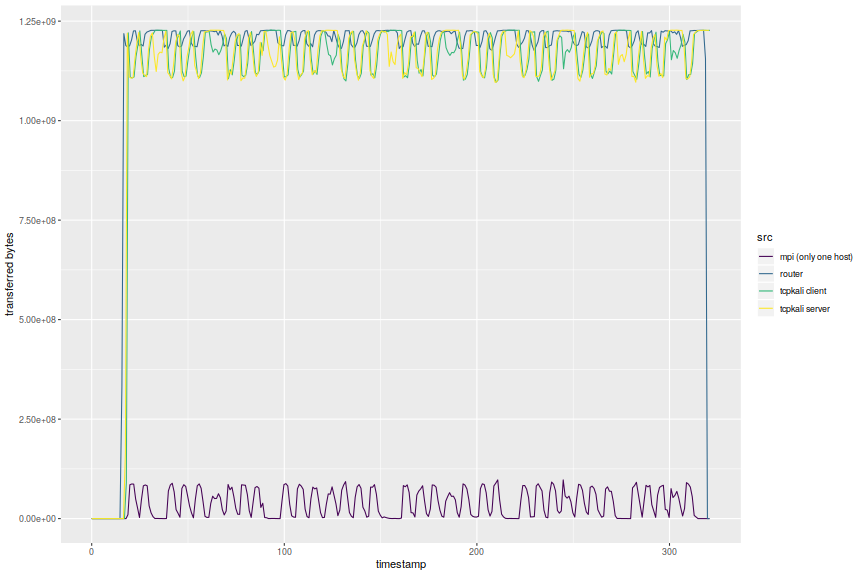

In [13]:
%%R -w 12 -h 8 --units in
library(tidyverse)
library(viridis)

instance = "../data/grisou/increase_comms_randhostfile_grisou/no_periods_1bcast/31bb41d8/"

test = read_table2(paste0(instance, "grisou-1.nancy.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "router", timestamp = timestamp - min(timestamp)) %>% 
    bind_rows( read_table2(paste0(instance, "grisou-10.nancy.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali client", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "grisou-33.nancy.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali server", timestamp = timestamp - min(timestamp)) ) %>% 
    bind_rows( read_table2(paste0(instance, "grisou-11.nancy.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "mpi (only one host)", timestamp = timestamp - min(timestamp)) ) 

test %>% mutate() %>% ggplot(aes(x = timestamp, y = txb)) + 
    ylab("transferred bytes") + 
    geom_line(aes(color = src)) + 
    scale_colour_viridis_d() + ggsave("/tmp/plot.png") 

## No interference

/nix/store/l81620lq18k9vjnl14xklp9zdm6wpprm-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Parsed with column specification:
cols(
  `#timestamp` = col_double(),
  cpu_cycles = col_double(),
  instructions = col_double(),
  rxp = col_double(),
  rxb = col_double(),
  txp = col_double(),
  txb = col_double(),
  X8 = col_logical()
)

  warnings.warn(x, RRuntimeWarning)
/nix/store/l81620lq18k9vjnl14xklp9zdm6wpprm-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Saving 12 x 8 in image

  warnings.warn(x, RRuntimeWarning)


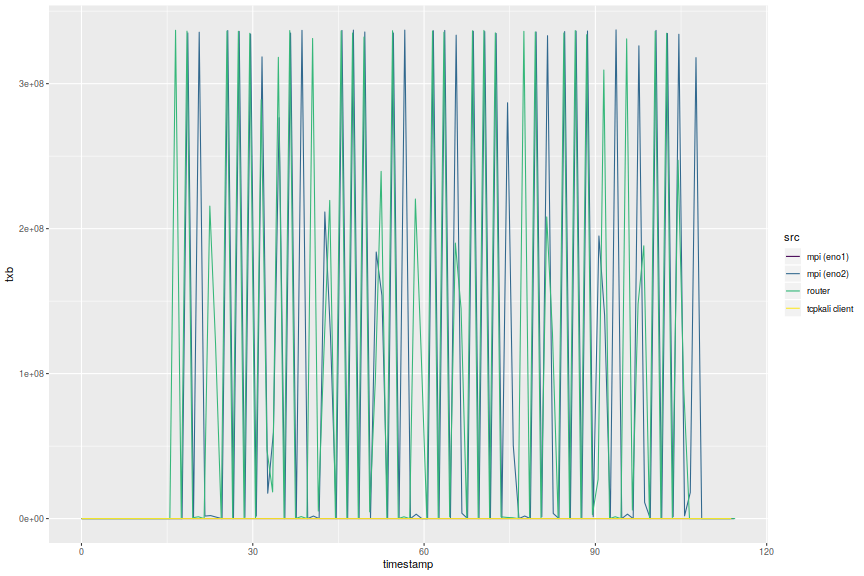

In [15]:
%%R -w 12 -h 8 --units in
library(tidyverse)

instance = "../data/grisou/increase_comms_randhostfile_grisou/no_kali_1bcast/00415e18/"

test = read_table2(paste0(instance, "grisou-1.nancy.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "router", timestamp = timestamp - min(timestamp)) %>% 
        bind_rows( read_table2(paste0(instance, "grisou-10.nancy.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali client", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "grisou-11.nancy.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "mpi (eno2)", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "grisou-11.nancy.grid5000.fr.eno1.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "mpi (eno1)", timestamp = timestamp - min(timestamp)) ) 

test %>% mutate() %>% ggplot(aes(x = timestamp, y = txb)) +
    geom_line(aes(color = src)) +
    scale_colour_viridis_d() + 
    ggsave("/tmp/plot.png")

## Periods 10s idle / 10s intereference

/nix/store/l81620lq18k9vjnl14xklp9zdm6wpprm-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Parsed with column specification:
cols(
  `#timestamp` = col_double(),
  cpu_cycles = col_double(),
  instructions = col_double(),
  rxp = col_double(),
  rxb = col_double(),
  txp = col_double(),
  txb = col_double(),
  X8 = col_logical()
)

  warnings.warn(x, RRuntimeWarning)
/nix/store/l81620lq18k9vjnl14xklp9zdm6wpprm-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Saving 12 x 8 in image

  warnings.warn(x, RRuntimeWarning)


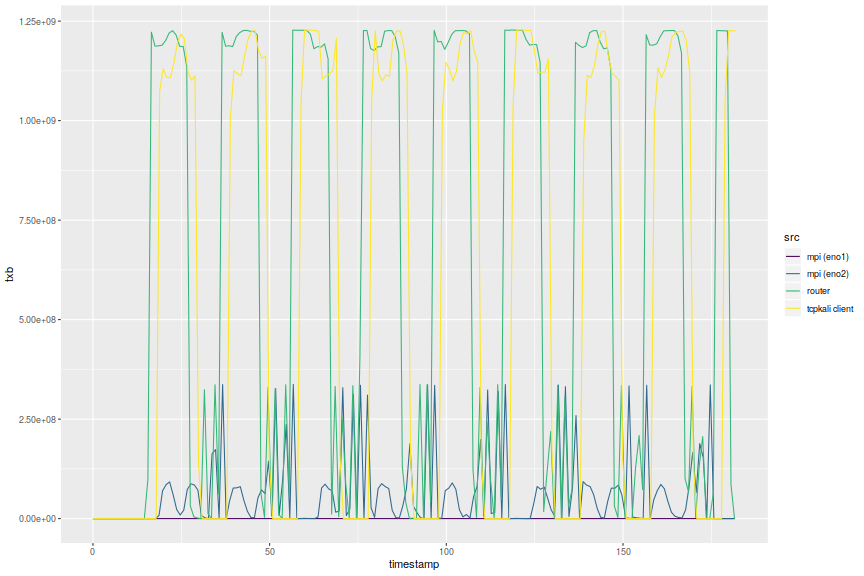

In [17]:
%%R -w 12 -h 8 --units in
library(tidyverse)

instance = "../data/grisou/increase_comms_randhostfile_grisou/periods10s_1bcast/327a38e9/"

test = read_table2(paste0(instance, "grisou-1.nancy.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "router", timestamp = timestamp - min(timestamp)) %>% 
        bind_rows( read_table2(paste0(instance, "grisou-10.nancy.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali client", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "grisou-11.nancy.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "mpi (eno2)", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "grisou-11.nancy.grid5000.fr.eno1.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "mpi (eno1)", timestamp = timestamp - min(timestamp)) ) 

test %>% mutate() %>% ggplot(aes(x = timestamp, y = txb)) +
    geom_line(aes(color = src)) +
    scale_colour_viridis_d() + 
    ggsave("/tmp/plot.png")